# Relatório Trabalho 2

### Aluna: Mayara Azevedo Aragão
### DRE:   115060969


Avaliação da disciplina EEL891 (Introdução ao Aprendizado de Máquina) no semestre 2020.01.
Escolhi implementar o algoritmo de Regressão para estimativa de preço de imóvel. 


In [1]:
# Bibliotecas utilizadas na construção do algoritmo:

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler, QuantileTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_squared_log_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor

Inicialmente é necessário importar o dataframe de treinamento e o de teste dados a serem treinados e testados, para elaborar uma análise dos dados que são fornecidos.

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy.stats import pearsonr
import seaborn as sns

dados_TREINO = pd.read_csv("conjunto_de_treinamento.csv")
dados_TESTE = pd.read_csv("conjunto_de_teste.csv")

dados = dados_TREINO
dados_teste = dados_TESTE


Analisando as colunas do dataframe que estão com dados não numéricos:

In [4]:
colunas = dados.columns
print('\nColunas do conjunto de treinamento:\n', colunas)

print("\n'tipo':\n", dados['tipo'].value_counts())
print("\n'tipo' - Conjunto TESTE:\n", dados_teste['tipo'].value_counts())

print("\n'tipo_vendedor':\n", dados['tipo_vendedor'].value_counts())
print("\n'tipo_vendedor'- Conjunto TESTE:\n", dados_teste['tipo_vendedor'].value_counts())


Colunas do conjunto de treinamento:
 Index(['Id', 'tipo', 'bairro', 'tipo_vendedor', 'quartos', 'suites', 'vagas',
       'area_util', 'area_extra', 'diferenciais', 'churrasqueira',
       'estacionamento', 'piscina', 'playground', 'quadra', 's_festas',
       's_jogos', 's_ginastica', 'sauna', 'vista_mar', 'preco'],
      dtype='object')

'tipo':
 Apartamento    4501
Casa            177
Loft              3
Quitinete         2
Name: tipo, dtype: int64

'tipo' - Conjunto TESTE:
 Apartamento    1924
Casa             75
Loft              1
Name: tipo, dtype: int64

'tipo_vendedor':
 Imobiliaria      4556
Pessoa Fisica     127
Name: tipo_vendedor, dtype: int64

'tipo_vendedor'- Conjunto TESTE:
 Imobiliaria      1958
Pessoa Fisica      42
Name: tipo_vendedor, dtype: int64


Percebemos que é possivel codificar as variaveis 'tipo' e 'tipo_vendedor'.

No caso, a variavel 'tipo_vendedor' pode ser tratada com um binarizador (LabelBinarizer) e a variavel 'tipo' com one-hot-encoding. Inicialmente, eu havia feito um mapeamento da categoria 'tipo', para valores de 1 a 4, pois é a cardinalidade dessa variável no conjunto de treinamento. Mas aperfeiçoando o modelo, utilizando one-hot-encoding obtive melhores resultados, portanto:

In [5]:
# Aplicando binarização na variavel "tipo_vendedor"

binarizador = LabelBinarizer()

for t in ['tipo_vendedor']:
    dados[t] = binarizador.fit_transform(dados[t])
    dados_teste[t] = binarizador.fit_transform(dados_teste[t])
    
print("\n'tipo_vendedor':\n", dados['tipo_vendedor'].value_counts())


'tipo_vendedor':
 0    4556
1     127
Name: tipo_vendedor, dtype: int64


Analisando o 'tipo' dos imóveis que estão disponíveis no conjunto de teste, é possivel perceber que há poucas ocorrências para o 'tipo' = 'Loft', e nenhuma ocorrencia para o 'tipo'='Quitinete' que aparece poucas vezes no conjunto de treino.
Portanto, ao fazer o one-hot-encoding, vou excluir do cálculo as colunas onde o 'tipo' do imovel seria 'Loft' ou 'Quitinete', e também excluir do conjunto de treinamento os dados com essas ocorrências, pois atrapalharam os resultados:

In [6]:
# Codificando o tipo do imovel com one-hot-encoding

dados = pd.get_dummies(dados, columns=['tipo'])
dados = dados[dados['tipo_Quitinete']==0]
# Excluindo a coluna 'tipo_Quitinete'
dados = dados.drop(['tipo_Quitinete'], axis=1)

dados = dados[dados['tipo_Loft']==0]
# Excluindo a coluna 'tipo_Loft'
dados = dados.drop(['tipo_Loft'], axis=1)

dados_teste = pd.get_dummies(dados_teste, columns=['tipo'])
# Excluindo a coluna 'tipo_Loft' do conjunto de teste
dados_teste = dados_teste.drop(['tipo_Loft'], axis=1)

Analisando as variaveis 'bairro' e 'diferenciais', percebemos que ambas tem cardinalidade alta:


In [7]:
print('\nPara contabilizar a cardinalidade das variaveis:\n')
print("Cardinalidade de'bairro':",len(dados['bairro'].unique().tolist()))
print("Cardinalidade de'diferenciais':",len(dados['diferenciais'].unique().tolist()))


Para contabilizar a cardinalidade das variaveis:

Cardinalidade de'bairro': 66
Cardinalidade de'diferenciais': 83


Contudo, na coluna 'diferenciais', estão as informações já dispostas ao lado nas colunas como 'piscina', 'churrasqueira', 'estacionamento', 'sauna' etc. Portanto, decidi alterar essa variável para um valor numérico que é a soma de algumas dessas variáveis já disponiveis no dataframe:

Após alguns testes, decidi retirar do calculo dos diferenciais as variaveis 'piscina' pois já é utilizada no cálculo da regressão:

In [8]:
dados['diferenciais'] = (dados['churrasqueira'] +  dados['playground'] + dados['s_jogos'] + dados['quadra'] +
                        dados['sauna']+dados['s_ginastica']+dados['s_festas'])

dados_teste['diferenciais'] =   (dados_teste['churrasqueira'] +  dados_teste['playground'] + dados_teste['s_jogos'] +
                                dados_teste['quadra'] + dados_teste['sauna'] + dados_teste['s_ginastica']  +
                                dados_teste['s_festas'])

print("Variavel 'diferenciais' após o ajuste:",dados['diferenciais'].unique().tolist())

Variavel 'diferenciais' após o ajuste: [0, 1, 2]


Agora, foi necessário aplicar uma transformação nos dados de 'bairro', para relacionar essa categoria com os dados, para isso, utilizei a função LabelEncoder e apliquei uma normalização nos dados:

In [9]:
label_encoder = LabelEncoder()
dados['bairro'] = label_encoder.fit_transform(dados['bairro'])
dados_teste['bairro'] = label_encoder.fit_transform(dados_teste['bairro'])

# Normalizando dados do LabelEncoder
mean = dados['bairro'].mean()
std = dados['bairro'].std()
dados['bairro'] = (dados['bairro'] - mean) / std


mean = dados_teste['bairro'].mean()
std = dados_teste['bairro'].std()
dados_teste['bairro'] = (dados['bairro'] - mean) / std

Como todas as categorias estão com valores numéricos, analisei o Coeficiente de Pearson para identificar as colunas que possuem maior relação com o alvo, que no caso é o preco do imovel:

In [10]:
colunas = dados.columns

print('\n           Coluna   Coef. Pears.   Confianca')
print('  ----------------   ------------   ---------')

for col in colunas:
    print( ' %16s   %12.4f   %9.4f' % (col, 
                                       pearsonr(dados[col],dados['preco'])[0], 
                                       pearsonr(dados[col],dados['preco'])[1]))
   



           Coluna   Coef. Pears.   Confianca
  ----------------   ------------   ---------
               Id        -0.0096      0.5099
           bairro        -0.0043      0.7691
    tipo_vendedor         0.1246      0.0000
          quartos         0.0208      0.1549
           suites         0.0421      0.0040
            vagas         0.0290      0.0472
        area_util         0.0275      0.0599
       area_extra         0.0011      0.9380
     diferenciais         0.0077      0.6002
    churrasqueira         0.0159      0.2772
   estacionamento        -0.0064      0.6627
          piscina         0.0068      0.6417
       playground        -0.0122      0.4030
           quadra        -0.0044      0.7636
         s_festas         0.0075      0.6072
          s_jogos        -0.0025      0.8619
      s_ginastica        -0.0023      0.8749
            sauna         0.0012      0.9356
        vista_mar         0.0076      0.6011
            preco         1.0000      0.0000
 tipo_Ap

Por uma questão lógica, o preço do imóvel não possui relação com o 'Id'. Além disso, a variavel 'diferenciais' possui alguma relação e já contabiliza grande parte de algumas variaveis fornecidas. Portando, vou excluir do cálculo algumas categorias.

O critério utilizado para exclusão dessas variaveis foi através de tentativa e erro, onde obtive melhores valores no resultado do RMSPE, métrica utilizada para avaliação na competição do Kaggle.

In [11]:
# Retirando algumas categorias dos dados:
    
dados = dados.drop(['Id','estacionamento', 'churrasqueira','playground','quadra',
                    's_festas', 's_jogos','sauna','s_ginastica', 'tipo_vendedor' ],
                    axis=1)

dados_teste = dados_teste.drop(['Id','estacionamento', 'churrasqueira','playground',
                                'quadra', 's_festas', 's_jogos','sauna', 's_ginastica', 'tipo_vendedor' ],
                                axis=1)

Para relacionar algumas categorias com o preco, fiz uma plotagem da média do preco utilizando grafico de barras:

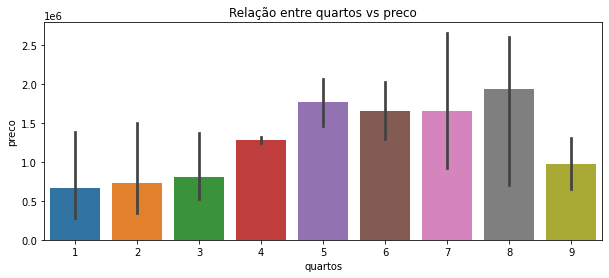

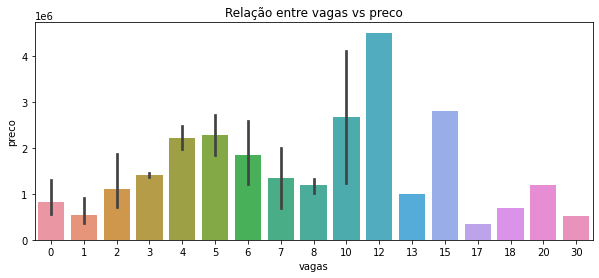

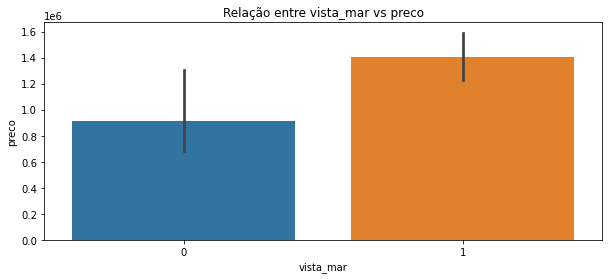

In [12]:
variaveis_discretas = ['quartos', 'vagas', 'vista_mar']

for col in variaveis_discretas:
    plt.figure(figsize = (10,4))
    plt.title('Relação entre '+ col+' vs preco')
    sns.barplot(x = col, y = 'preco', data = dados)
    plt.show()
   

/srv/conda/envs/notebook/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

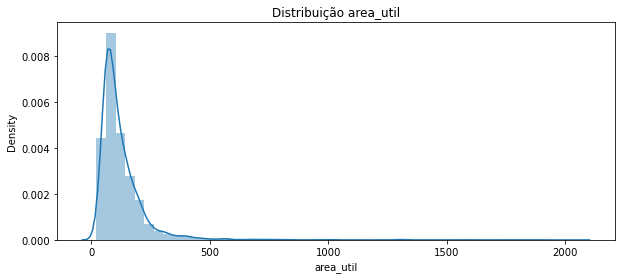

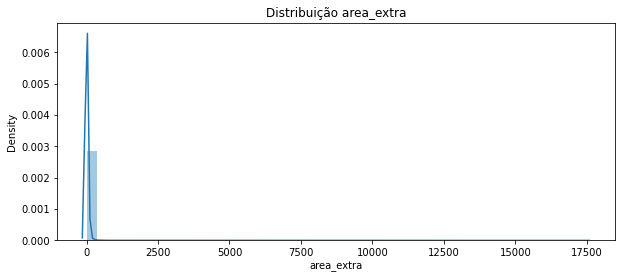

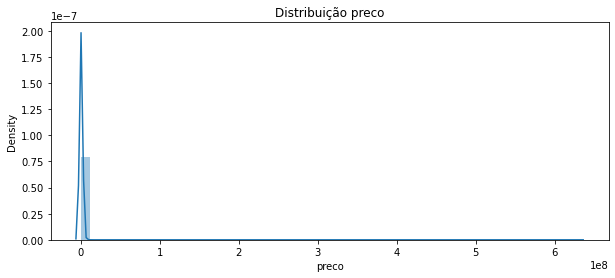

In [13]:
# Analisando as relações entre a densidade de algumas variaveis continuas

variaveis_continuas = ['area_util', 'area_extra', 'preco']

for col in variaveis_continuas:
    
    plt.figure(figsize = (10,4))
    plt.title('Distribuição '+ col)
    sns.distplot(dados[col]);


É possível observar pelo gráfico que a há poucos imóveis na categoria area_extra acima de uns 200m pelo menos, e area_util acima de 500m aproximadamente:

/srv/conda/envs/notebook/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


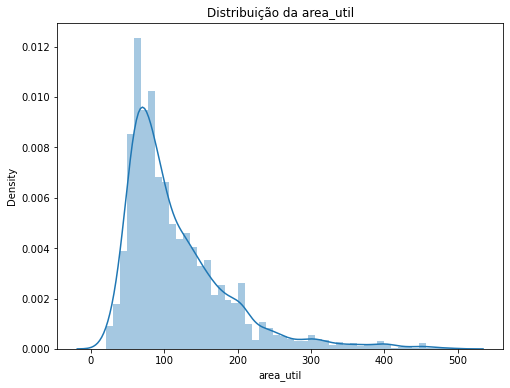

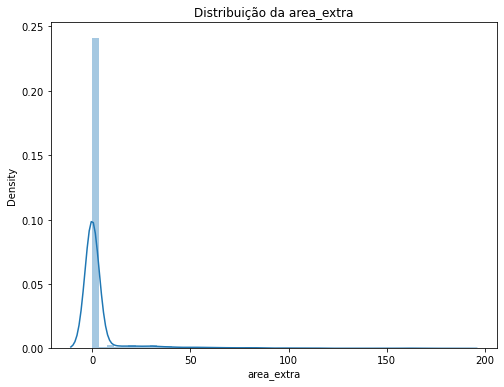

In [14]:
plt.figure(figsize = (8,6))
plt.title('Distribuição da area_util')
sns.distplot(dados[dados['area_util']<500]['area_util']);

plt.figure(figsize = (8,6))
plt.title('Distribuição da area_extra')
sns.distplot(dados[dados['area_extra']<200]['area_extra']);

Analisando agora a densidade das amostras pela categoria alvo que é 'preco':

/srv/conda/envs/notebook/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


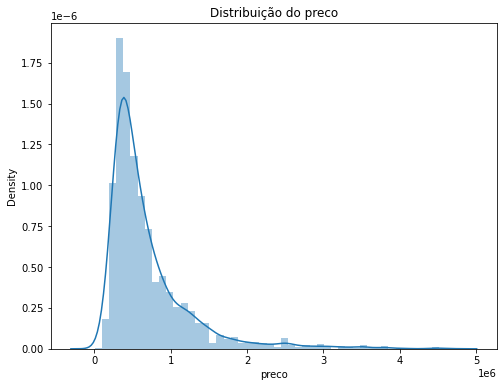

In [15]:
plt.figure(figsize = (8,6))
plt.title('Distribuição do preco')
sns.distplot(dados[dados['preco']<5*pow(10,6)]['preco']);

É possível observar pelo gráfico que a maior parte das amostras estão entre 0 e 2x10^6. Contudo, com a métrica utilizada, eliminar os dados outliers que contém preço maior que 10^6 foi o melhor ajuste encontrado. Portando, para o treinamento, vou excluir os dados que passam dessa margem na categoria de preço, e também dos que passam 200m da categoria 'area_extra' e 500m da categoria 'area_util':

In [16]:

dados = dados[dados['preco']<=pow(10,6)]
dados = dados[dados['area_extra']<200]
dados = dados[dados['area_util']<500]


Categorias restantes para o treinamento dos dados:

In [17]:
colunas = dados.columns
print(colunas)

Index(['bairro', 'quartos', 'suites', 'vagas', 'area_util', 'area_extra',
       'diferenciais', 'piscina', 'vista_mar', 'preco', 'tipo_Apartamento',
       'tipo_Casa'],
      dtype='object')


Separar x e y em conjunto teste e treinamento, dentro dos dados dados para treinamento:

In [18]:

x = dados.drop(['preco'], axis=1).to_numpy()
y = dados['preco'].to_numpy()

x_TESTE = dados_teste.iloc[:,:].to_numpy()
y_TESTE_Id = dados_teste.iloc[:,0] # dataframe com coluna Id para adicionar à resposta final no arquivo csv


Utilizando a função train_test_split para separar o conjunto de dados em treino e teste para cálculo da precisão do modelo:

In [19]:

x_treino, x_teste, y_treino, y_teste = train_test_split(
    x,
    y,
    test_size=0.20, # separando 1/4 teste
    random_state=0, # sorteio aleatorio
    )


Para ajustar a escala dos atributos, a melhor escolha encontrada foi utilizando QuantileTransformer, após ser testado com RobustScaler, e também com StandartScaler. Uma motivação para a escolha dessa escala é pelo bom tratamento de outliers e pelo resultado no RMSPE.

In [20]:
# Ajustar a escala dos atributos 

# Melhores resultados com:
escala = QuantileTransformer()

escala.fit(x_treino)

x_treino = escala.transform(x_treino)
x_teste = escala.transform(x_teste)

# Ajustar a escala dos atributos do conjunto de TESTE dado no arquivo 'conjunto_de_teste.csv'
x_TESTE = escala.transform(x_TESTE)

Para a métrica dos dados, foi solicitado medir a raiz quadrada do erro percentual quadrático médio. 
Definindo a funcao rmspe():

In [21]:
# Definindo métrica de cálculo RMSPE

def rmspe(y, y_resposta):
    value = np.sqrt(np.mean(np.square(((y - y_resposta) / y)), axis=0))
    return value


Agora, os dados estão prontos para serem modelados. Para achar o melhor modelo de acordo com a métrica escolhida, eu tentei fazer alguns tipos de regressão. Alguns exemplos são dados a seguir:

In [22]:
#--------------------------------------------------------------------
# Treinar um regressor LINEAR
#--------------------------------------------------------------------

regressor_linear = LinearRegression()
regressor_linear = regressor_linear.fit(x_treino,y_treino)

y_resposta_treino = regressor_linear.predict(x_treino)
y_resposta_teste = regressor_linear.predict(x_teste)

# Calcular as métricas e comparar os resultados

mse_in = mean_squared_error(y_treino, y_resposta_treino)
rmse_in = math.sqrt(mse_in)
r2_in = r2_score(y_treino, y_resposta_treino)
rmspe_in = rmspe(y_treino, y_resposta_treino)

mse_out = mean_squared_error(y_teste, y_resposta_teste)
rmse_out = math.sqrt(mse_out)
r2_out = r2_score(y_teste, y_resposta_teste)
rmspe_out = rmspe(y_teste, y_resposta_teste)

print('\n REGRESSOR LINEAR\n')

print(' Métrica   DENTRO da amostra   FORA da amostra ')
print(' -------   -----------------   --------------- ')

print(' %7s   %17.4f   %15.4f ' % ( 'rmse' , rmse_in, rmse_out) )
print(' %7s   %17.4f   %15.4f ' % ( 'r2' , r2_in, r2_out) )
print(' %7s   %17.4f   %15.4f ' % ( 'rmspe' , rmspe_in, rmspe_out) )



 REGRESSOR LINEAR

 Métrica   DENTRO da amostra   FORA da amostra 
 -------   -----------------   --------------- 
    rmse         107723.1192       108831.0893 
      r2              0.7266            0.7209 
   rmspe              4.2793            0.2689 


In [23]:
#-------------------------------------------------------------------------
# Treinar e testar um regressor KNN para varios valores do parametro k
#-------------------------------------------------------------------------

print('\n REGRESSOR KNN\n')
print('  K    DENTRO da amostra   FORA da amostra ')
print(' ---   -----------------   --------------- ')

for k in range(10,41,2):
    regressor_knn = KNeighborsRegressor(
        n_neighbors = k,
        p=1,
        n_jobs=4,
        algorithm = 'kd_tree',
        weights = 'distance', #zera os valores dentro da amostra
        )
    
    regressor_knn = regressor_knn.fit(x_treino,y_treino)

    y_resposta_treino = regressor_knn.predict(x_treino)
    y_resposta_teste = regressor_knn.predict(x_teste)
        
    rmspe_in = rmspe(y_treino, y_resposta_treino)
    rmspe_out = rmspe(y_teste, y_resposta_teste)

    print(' %3d   %17.4f   %15.4f ' % ( k , rmspe_in, rmspe_out) ) 


 REGRESSOR KNN

  K    DENTRO da amostra   FORA da amostra 
 ---   -----------------   --------------- 
  10              0.0634            0.2334 
  12              0.0634            0.2333 
  14              0.0634            0.2328 
  16              0.0634            0.2322 
  18              0.0634            0.2327 
  20              0.0634            0.2327 
  22              0.0634            0.2332 
  24              0.0634            0.2335 
  26              0.0634            0.2338 
  28              0.0634            0.2341 
  30              0.0634            0.2340 
  32              0.0634            0.2348 
  34              0.0634            0.2350 
  36              0.0634            0.2350 
  38              0.0634            0.2356 
  40              0.0634            0.2362 


In [24]:
#-------------------------------------------------------------------------
# Treinar e testear um regressor POLINOMIAL para graus de 1 a 2
#-------------------------------------------------------------------------

print('\n REGRESSOR POLINOMIAL DE GRAU K\n')
print('  K    Nº at   DENTRO da amostra   FORA da amostra ')
print(' ---   -----   -----------------   --------------- ')

for k in range(1,3):
    pf = PolynomialFeatures(degree=k)
    
    pf = pf.fit(x_treino)
    x_treino_poly = pf.transform(x_treino)
    x_teste_poly = pf.transform(x_teste)
    
    regressor_linear = LinearRegression()
    regressor_linear = regressor_linear.fit(x_treino_poly,y_treino)

    y_resposta_treino = regressor_linear.predict(x_treino_poly)
    y_resposta_teste = regressor_linear.predict(x_teste_poly)
    
    rmspe_in = rmspe(y_treino, y_resposta_treino)
    rmspe_out = rmspe(y_teste, y_resposta_teste)
    
    n_atributos = x_treino_poly.shape[1]    

    print(' %3d   %5d   %17.4f   %15.4f ' % ( k , n_atributos, rmspe_in, rmspe_out) ) 



 REGRESSOR POLINOMIAL DE GRAU K

  K    Nº at   DENTRO da amostra   FORA da amostra 
 ---   -----   -----------------   --------------- 
   1      12              4.2793            0.2689 
   2      78              4.8512            0.2519 


In [25]:
#----------------------------------------------------------------------
# Treinar e testar um regressor SGD com função de perda 'squared_loss'
#----------------------------------------------------------------------

print('\n REGRESSOR SGD:\n')

regressor_sgd = SGDRegressor(
    loss='squared_loss',
    alpha=0,
    penalty='elasticnet',
    tol=1e-6,
    l1_ratio= 0.2,
    learning_rate='adaptive',
    max_iter=1000000,
    )

regressor_sgd = regressor_sgd.fit(x_treino,y_treino)

y_resposta_treino = regressor_sgd.predict(x_treino)
y_resposta_teste = regressor_sgd.predict(x_teste)
    
print(' Métrica   DENTRO da amostra   FORA da amostra ')
print(' -------   -----------------   --------------- ')

mse_in = mean_squared_error(y_treino, y_resposta_treino)
rmse_in = math.sqrt(mse_in)
r2_in = r2_score(y_treino, y_resposta_treino)
rmspe_in = rmspe(y_treino, y_resposta_treino)

mse_out = mean_squared_error(y_teste, y_resposta_teste)
rmse_out = math.sqrt(mse_out)
r2_out = r2_score(y_teste, y_resposta_teste)
rmspe_out = rmspe(y_teste, y_resposta_teste)

print(' %7s   %17.4f   %15.4f ' % ( 'rmse' , rmse_in, rmse_out) )
print(' %7s   %17.4f   %15.4f ' % ( 'r2' , r2_in, r2_out) )
print(' %7s   %17.4f   %15.4f ' % ( 'rmspe' , rmspe_in, rmspe_out) )



 REGRESSOR SGD:

 Métrica   DENTRO da amostra   FORA da amostra 
 -------   -----------------   --------------- 
    rmse         107723.2812       108825.3520 
      r2              0.7266            0.7210 
   rmspe              4.2764            0.2689 


Contudo, os melhores resultados obtidos, foram encontrados com o regressorRandomForest ( RMSPE = 0.2244) e com o HistGradientBoosting  ( RMSPE = 0.2062) :

In [26]:
#----------------------------------------------------------------------
# Treinar e testar um regressorRandomForest
#----------------------------------------------------------------------

print('\n REGRESSOR RANDOM FOREST:\n')

rf = RandomForestRegressor(
    n_estimators=2000,
    random_state=0,
    min_samples_leaf=2,
    n_jobs=10,
    criterion='mse',
    verbose =0,
    )

rf.fit(x_treino, y_treino)

y_resposta_treino = rf.predict(x_treino)
y_resposta_teste = rf.predict(x_teste)

print(' Métrica   DENTRO da amostra   FORA da amostra ')
print(' -------   -----------------   --------------- ')
rmspe_in = rmspe(y_treino, y_resposta_treino)
rmspe_out = rmspe(y_teste, y_resposta_teste)
print(' %7s   %17.4f   %15.4f ' % ( 'rmspe' , rmspe_in, rmspe_out) )

# REGRESSOR RANDOM FOREST:
# 
# Métrica   DENTRO da amostra   FORA da amostra 
# -------   -----------------   --------------- 
#    rmse          58252.8740        93237.5561 
#      r2              0.9201            0.7952 
#   MSLE:              0.0300            0.0400 
#   rmspe              3.4555            0.2248 
 


 REGRESSOR RANDOM FOREST:

 Métrica   DENTRO da amostra   FORA da amostra 
 -------   -----------------   --------------- 
   rmspe              3.4385            0.2241 


In [27]:
#----------------------------------------------------------------------
# Treinar e testar um regressor HistGradientBoosting
#----------------------------------------------------------------------

print('\n REGRESSOR HIST GRADIENT BOOSTING:\n')

hgb = HistGradientBoostingRegressor(
    l2_regularization=12.0,
    max_iter=70,
    learning_rate=0.1,
    loss='least_absolute_deviation'
    )

hgb = hgb.fit(x_treino, y_treino)

y_resposta_treino = hgb.predict(x_treino)
y_resposta_teste = hgb.predict(x_teste)


print(' Métrica   DENTRO da amostra   FORA da amostra ')
print(' -------   -----------------   --------------- ')
rmspe_in = rmspe(y_treino, y_resposta_treino)
rmspe_out = rmspe(y_teste, y_resposta_teste)
print(' %7s   %17.4f   %15.4f ' % ( 'rmspe' , rmspe_in, rmspe_out) )


# REGRESSOR HIST GRADIENT BOOSTING - Resultados obtidos no Spyder:
 
# Métrica   DENTRO da amostra   FORA da amostra 
# -------   -----------------   --------------- 
#    rmse          83208.8547        94002.0092 
#      r2              0.8369            0.7918 
#   MSLE:              0.0400            0.0400 
#   rmspe              5.2947            0.2062 


 REGRESSOR HIST GRADIENT BOOSTING:

 Métrica   DENTRO da amostra   FORA da amostra 
 -------   -----------------   --------------- 
   rmspe              5.2947            0.2062 


Como o modelo está com bons valores para a métrica solicitada RMSPE, passar pelo modelo os dados de teste fornecidos no arquivo 'conjunto_de_teste.csv' e salvar no dataframe 'out.csv' para enviar para a competição do Kaggle:

In [28]:
#--------------------------------------------------------------------
# Aplicar o modelo com RMSPE = 0.2062 no conjunto de teste:
#----------------------------------------------------------------------

y_resposta_TESTE = hgb.predict(x_TESTE)
d = {'Id': y_TESTE_Id , 'preco': y_resposta_TESTE}
df = pd.DataFrame(data=d)


df.to_csv('out.csv', index=False)
dados_output =  pd.read_csv("out.csv")